proof of concept notebook as a scaffolding of our project, feel free to edit and refine as needed. I think in the end we should put all of these functions in a .py file and make a seaparate notebook for presenting.

In [5]:
import numpy as np
import matplotlib.pyplot as plt


### define the prior over the parameters

If mode=Normal or mode=Uniform gives each parameter identical normal/uniform priors. mode=None allows us to set different arbitrary function for each prior. prior_1, prior_2, prior_3, prior_4 is what we have to edit to fit the new task (hopefully the priors dont actually depend on where we are in parameter space).

In [6]:
def prior(params, mode='uniform'):
    if mode == 'normal' :
        return np.prod(np.exp(-(params**2)))
    if mode == 'uniform' :
        return 1
    else :
        p1, p2, p3, p4 = params
        prior_1 = abs(p1/np.sum(params))
        prior_2 = abs(p2/np.sum(params))
        prior_3 = abs(p3/np.sum(params))
        priot_4 = abs(p4/np.sum(params))
        return [prior_1*prior_2*prior_3*prior_4]


### define the likelihood given a set of parameters and a data set
pretty straightforward, we calculate the marginal probabilities of each data point and then take the product to find the joint probability(probability of the whole data set). marginal_probs is the part we will have to edit to fit our new task.

In this example we are just using p1 as an estimate of e and p3 as an estimate of the offset, assuming a guassian signal. This is just a test case. Our actual likelihood function will call upon the luminosity data and the function $\mu(params,data)$.

In [7]:
def likelihood(params, data):
    p1, p2, p3, p4 = params
    marginal_probs=np.sqrt(np.log(p1)) * p1**(-(data-p3)**2/2)
    return np.prod(marginal_probs)


### metropolis part

Everything nontrivial is defined elsewhere, this is just a very straightforward fuction that returns False if we reject the candidate and True if we accept (uses the metropolis algorithm to accept/refect)


Note that this fuction calls both the "likelyhood" and the "prior" function

In [16]:
def metropolis(params, candidate_params, data, prior_func=prior, likelihood_func=likelihood, prior_mode = 'uniform'):
    
    def get_prob(params):
        return prior_func(params, mode=prior_mode)*likelihood_func(params, data)
    
    threshhold = min(1, get_prob(candidate_params)/get_prob(params))
    decide=np.random.uniform(0,1,1)
    
    if threshhold > decide:
        return(True)
    if threshhold < decide:
        return(False)


### the chain
Again, everything nontrivial is elsewhere. The main art here is definig the proper starting point and variance for your start_state and variances inputs. The defaults are tuned so that the algorithm doesnt decay to less than 1 before starting to converge for our test case. 

### the convergence test
simple convergence test that looks at the last 2*N. Convergence is defined as when the average over the first N steps is within some margin of the average over the second N steps for each parameter. Currently it is hardcorded to just look at p1 and p3, for obvious reasons.

In [9]:
def chain(data, max_trials=10000, convergence_window=50, convergence_threshhold=.001, start_state= np.ones(4)+1, variances=np.ones(4)/5):
    '''
    data is the data set
    max_trials is to prevent it from taking too long if it gets stuck without convergence
    convergence_window is how large a range it averages over for convergence
    convergence_threshhold is the maximum allowed percent change for reaching convergence 
    start_state is the initial values for all parameters: np array of length 4
    variances is the variance for each generating gaussian: np array of length 4
    '''
    chain=[]
    current = start_state
    i=0
    convergence = False
    while convergence == False and i < max_trials:
        candidate = np.random.normal(current,variances)
        i += 1
        if metropolis(current, candidate, data):
            chain.append(candidate)
            current = candidate
        convergence = convergence_test(chain, convergence_window, convergence_threshhold)

    print('trials:{}'.format(i))
    if convergence == False:
        print('convergence failed')
    return(np.asarray(chain))

def convergence_test(chain, convergence_window, convergence_threshhold):
        if len(chain) > 2*convergence_window:
            old_means = np.mean(chain[-2*convergence_window + 1: -convergence_window], axis=0)
            new_means = np.mean(chain[-convergence_window: -1], axis=0)
            diff = abs(new_means - old_means)/abs(old_means)
            # here we hardcode it to look at just the max change in p1 and p3
            if max(diff[0],diff[2]) < convergence_threshhold:
                return True
            else:
                return False
        else:
            return False

### test in a simple case

we expect for $p1$ to converge to $e$ and $p3$ to converge to 1. $p2$ and $p4$ should not converge because they didnt play into the likelihood


In [24]:
data = np.random.normal(1,1,100)

chn = chain(data)

trials:5506


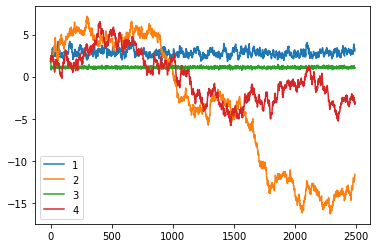

In [25]:
plt.plot(chn)
plt.legend('1234')

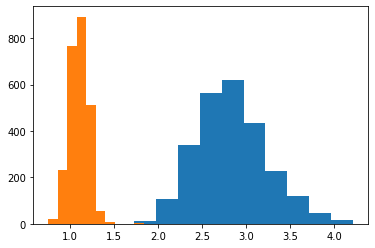

In [26]:
plt.hist(chn[:,0]);
plt.hist(chn[:,2]);

looks alright